<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M2-scopus-AAUBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

In [39]:
# explainability (why did the model say it's related to this author)
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pandas as pd
import numpy as np
import preprocessor as prepro # text prepro
import tqdm #progress bar

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

In [41]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [46]:
data = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/scopus_aaubs.csv')

In [43]:
data.shape

(135, 54)

In [44]:
data.columns

Index(['Authors', 'Author(s) ID', 'Title', 'Year', 'Source title', 'Volume',
       'Issue', 'Art. No.', 'Page start', 'Page end', 'Page count', 'Cited by',
       'DOI', 'Link', 'Affiliations', 'Authors with affiliations', 'Abstract',
       'Author Keywords', 'Index Keywords', 'Molecular Sequence Numbers',
       'Chemicals/CAS', 'Tradenames', 'Manufacturers', 'Funding Details',
       'Funding Text 1', 'Funding Text 2', 'Funding Text 3', 'Funding Text 4',
       'Funding Text 5', 'Funding Text 6', 'Funding Text 7', 'Funding Text 8',
       'Funding Text 9', 'Funding Text 10', 'References',
       'Correspondence Address', 'Editors', 'Sponsors', 'Publisher',
       'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')

In [45]:
data

,Authors,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,...,ISBN,CODEN,PubMed ID,Language of Original Document,Abbreviated Source Title,Document Type,Publication Stage,Open Access,Source,EID
0,"Karam A., Reinau K.H., Østergaard C.R.",56808965600;55881012800;57572924800;,Correction: Horizontal collaboration in the fr...,2022,European Transport Research Review,14,1,14,NaN,NaN,...,NaN,NaN,NaN,English,Eur. Transp. Res. Rev.,Erratum,Final,"All Open Access, Gold",Scopus,2-s2.0-85128078368
1,Lennon N.J.,57203245915;,Balancing incremental and radical innovation t...,2022,Journal of High Technology Management Research,33,2,100439,NaN,NaN,...,NaN,JTMRE,NaN,English,J. High Technol. Manage. Res.,Article,Final,"All Open Access, Hybrid Gold, Green",Scopus,2-s2.0-85134230589
2,"Nazifi A., Roschk H., Villarroel Ordenes F., M...",57204639792;35604545800;56233503500;55069712000;,Bad Intentions: Customers’ Negative Reactions ...,2022,Journal of Travel Research,61,8,NaN,1808,1827,...,NaN,NaN,NaN,English,J. Travel Res.,Article,Final,"All Open Access, Hybrid Gold, Green",Scopus,2-s2.0-85117161018
3,"Zhang H., Hu Y., Shi X., Gao Y.",57169423400;56580618100;57202847716;57196280682;,When and how do innovation ecosystems outperfo...,2022,Industrial Management and Data Systems,122,9,NaN,2091,2120,...,NaN,IMDSD,NaN,English,Ind Manage Data Sys,Article,Final,NaN,Scopus,2-s2.0-85135626284
4,"Hennart J.-F., Verbeke A.",7003448343;6603960214;,Actionable and enduring implications of Oliver...,2022,Journal of International Business Studies,53,8,NaN,1557,1575,...,NaN,NaN,NaN,English,J. Int. Bus. Stud.,Editorial,Final,"All Open Access, Bronze",Scopus,2-s2.0-85139183209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,"Hertel F., Wicmandy M.",57207916203;57222105086;,Metaphorical creativity: an aspect of everyday...,2020,Development and Learning in Organizations,35,5,NaN,15,18,...,NaN,NaN,NaN,English,Dev. Learn. Organ.,Article,Final,NaN,Scopus,2-s2.0-85101469637
131,"Brøns Kringelum L., Brix J.",57204126464;55329326500;,Critical realism and organizational learning,2020,Learning Organization,28,1,NaN,32,45,...,NaN,NaN,NaN,English,Learn. Organ.,Article,Final,"All Open Access, Hybrid Gold, Green",Scopus,2-s2.0-85098526945
132,"Arvidsson H.G.S., Coudounaris D.N.",57219209143;35271722300;,Effectuation versus causation: A case study of...,2020,International Journal of Entrepreneurship,24,4,NaN,1,13,...,NaN,NaN,NaN,English,Int. J. Enterp.,Article,Final,NaN,Scopus,2-s2.0-85091709482
133,Andersen E.S.,7202323056;,Schumpeter and regional innovation,2011,Handbook of Regional Innovation and Growth,NaN,NaN,NaN,32,42,...,9780857931504; 9781848444171,NaN,NaN,English,Handb. of Regional Innovation and Growth,Book Chapter,Final,NaN,Scopus,2-s2.0-84881869587


In [9]:
data[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

,Authors,Author(s) ID,Title,Abstract,Year,Source title
0,"Karam A., Reinau K.H., Østergaard C.R.",56808965600;55881012800;57572924800;,Correction: Horizontal collaboration in the fr...,Following the publication of the original arti...,2022,European Transport Research Review
1,Lennon N.J.,57203245915;,Balancing incremental and radical innovation t...,The literature has discussed the introduction ...,2022,Journal of High Technology Management Research
2,"Nazifi A., Roschk H., Villarroel Ordenes F., M...",57204639792;35604545800;56233503500;55069712000;,Bad Intentions: Customers’ Negative Reactions ...,"Intentional service failures (e.g., overbookin...",2022,Journal of Travel Research
3,"Zhang H., Hu Y., Shi X., Gao Y.",57169423400;56580618100;57202847716;57196280682;,When and how do innovation ecosystems outperfo...,Purpose: Studies have documented the distincti...,2022,Industrial Management and Data Systems
4,"Hennart J.-F., Verbeke A.",7003448343;6603960214;,Actionable and enduring implications of Oliver...,[No abstract available],2022,Journal of International Business Studies
...,...,...,...,...,...,...
130,"Hertel F., Wicmandy M.",57207916203;57222105086;,Metaphorical creativity: an aspect of everyday...,"Purpose: According to Mumford et al. (2018), c...",2020,Development and Learning in Organizations
131,"Brøns Kringelum L., Brix J.",57204126464;55329326500;,Critical realism and organizational learning,Purpose: This study aims to investigate the im...,2020,Learning Organization
132,"Arvidsson H.G.S., Coudounaris D.N.",57219209143;35271722300;,Effectuation versus causation: A case study of...,The purpose of this paper is to investigate th...,2020,International Journal of Entrepreneurship
133,Andersen E.S.,7202323056;,Schumpeter and regional innovation,[No abstract available],2011,Handbook of Regional Innovation and Growth


In [10]:
data = data[['Authors', 'Author(s) ID','Title', 'Abstract','Year', 'Source title']]

In [11]:
data ['text'] = data['Title'] + '. ' + data['Abstract']

In [12]:
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))
data['text_clean'] = data['text_clean'].str.replace('#','')

In [13]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/135 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 94%|█████████▍| 127/135 [00:01<00:00, 140.14it/s]

In [14]:
# write everything into one function that can be re-used later
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  removes twitter stuff
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))
  texts_clean = texts_clean.str.replace('#','')

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [15]:
# apply all prepro-pipeline to texts
data['text_clean'] = text_prepro(data['text'])

100%|██████████| 135/135 [00:01<00:00, 86.74it/s] 


In [ ]:
data

,id,text,author,text_clean
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...
1,id17569,It never once occurred to me that the fumbling...,HPL,occurred fumbling mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding gold superintendent abandoned attempts...
...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright
19577,id17513,"For an item of news like this, it strikes us i...",EAP,item news like strikes coolly received


In [16]:
# preprocess texts (we need tokens)
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [17]:
data['tokens'] = tokens

In [18]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data['tokens'])
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data['tokens']]

In [19]:
corpus

[[(0, 2),
  (1, 3),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 3)],
 [(1, 1),
  (7, 1),
  (15, 4),
  (16, 1),
  (17, 5),
  (18, 1),
  (19, 2),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 2),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 1),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 2),
  (44, 1)],
 [(0, 1),
  (11, 1),
  (12, 1),
  (16, 1),
  (24, 2),
  (40, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 2),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 7),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 3),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 2),
  (68, 1)],
 [(1, 4),
  (16, 1),
  (21, 1),
  (25, 2),
  (28, 5),
  (30, 1),
  (33, 1),
  (34, 1),
  (36, 4),
  (39, 1),
  (41, 7),
  (42, 2),
  (44, 1),
  (54, 1),
  (55, 6),

In [20]:
# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=5, workers = 4, passes=10)

In [21]:
# Let's try to visualize
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [22]:
 # Let's Visualize
pyLDAvis.display(lda_display)

In [23]:
# cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
# coherence = cm.get_coherence()  # get coherence value

In [24]:
data = data.reset_index()

In [25]:
data.shape

(135, 10)

In [26]:
data = data[data["tokens"].str.len() != 0]

In [28]:
data

,index,Authors,Author(s) ID,Title,Abstract,Year,Source title,text,text_clean,tokens
0,0,"Karam A., Reinau K.H., Østergaard C.R.",56808965600;55881012800;57572924800;,Correction: Horizontal collaboration in the fr...,Following the publication of the original arti...,2022,European Transport Research Review,Correction: Horizontal collaboration in the fr...,correction horizontal collaboration freight tr...,"[correction, horizontal, collaboration, freigh..."
1,1,Lennon N.J.,57203245915;,Balancing incremental and radical innovation t...,The literature has discussed the introduction ...,2022,Journal of High Technology Management Research,Balancing incremental and radical innovation t...,balancing incremental radical innovation perfo...,"[incremental, radical, innovation, performance..."
2,2,"Nazifi A., Roschk H., Villarroel Ordenes F., M...",57204639792;35604545800;56233503500;55069712000;,Bad Intentions: Customers’ Negative Reactions ...,"Intentional service failures (e.g., overbookin...",2022,Journal of Travel Research,Bad Intentions: Customers’ Negative Reactions ...,bad intentions customers negative reactions in...,"[bad, intention, customer, negative, reaction,..."
3,3,"Zhang H., Hu Y., Shi X., Gao Y.",57169423400;56580618100;57202847716;57196280682;,When and how do innovation ecosystems outperfo...,Purpose: Studies have documented the distincti...,2022,Industrial Management and Data Systems,When and how do innovation ecosystems outperfo...,innovation ecosystems outperform integrated or...,"[innovation, ecosystem, integrated, organizati..."
4,4,"Hennart J.-F., Verbeke A.",7003448343;6603960214;,Actionable and enduring implications of Oliver...,[No abstract available],2022,Journal of International Business Studies,Actionable and enduring implications of Oliver...,actionable enduring implications oliver willia...,"[actionable, implication, oliver, williamson, ..."
...,...,...,...,...,...,...,...,...,...,...
130,130,"Hertel F., Wicmandy M.",57207916203;57222105086;,Metaphorical creativity: an aspect of everyday...,"Purpose: According to Mumford et al. (2018), c...",2020,Development and Learning in Organizations,Metaphorical creativity: an aspect of everyday...,metaphorical creativity aspect everyday creati...,"[metaphorical, creativity, aspect, everyday, c..."
131,131,"Brøns Kringelum L., Brix J.",57204126464;55329326500;,Critical realism and organizational learning,Purpose: This study aims to investigate the im...,2020,Learning Organization,Critical realism and organizational learning. ...,critical realism organizational learning purpo...,"[critical, realism, organizational, learning, ..."
132,132,"Arvidsson H.G.S., Coudounaris D.N.",57219209143;35271722300;,Effectuation versus causation: A case study of...,The purpose of this paper is to investigate th...,2020,International Journal of Entrepreneurship,Effectuation versus causation: A case study of...,effectuation versus causation case study recru...,"[effectuation, causation, case, study, recruit..."
133,133,Andersen E.S.,7202323056;,Schumpeter and regional innovation,[No abstract available],2011,Handbook of Regional Innovation and Growth,Schumpeter and regional innovation. [No abstra...,schumpeter regional innovation abstract available,"[schumpeter, regional, innovation, abstract, a..."


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [30]:
corpus = data['tokens']

In [31]:
corpus

0      [correction, horizontal, collaboration, freigh...
1      [incremental, radical, innovation, performance...
2      [bad, intention, customer, negative, reaction,...
3      [innovation, ecosystem, integrated, organizati...
4      [actionable, implication, oliver, williamson, ...
                             ...                        
130    [metaphorical, creativity, aspect, everyday, c...
131    [critical, realism, organizational, learning, ...
132    [effectuation, causation, case, study, recruit...
133    [schumpeter, regional, innovation, abstract, a...
134    [venture, capital, regional, innovation, growt...
Name: tokens, Length: 135, dtype: object

In [32]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [33]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [34]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [35]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [36]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

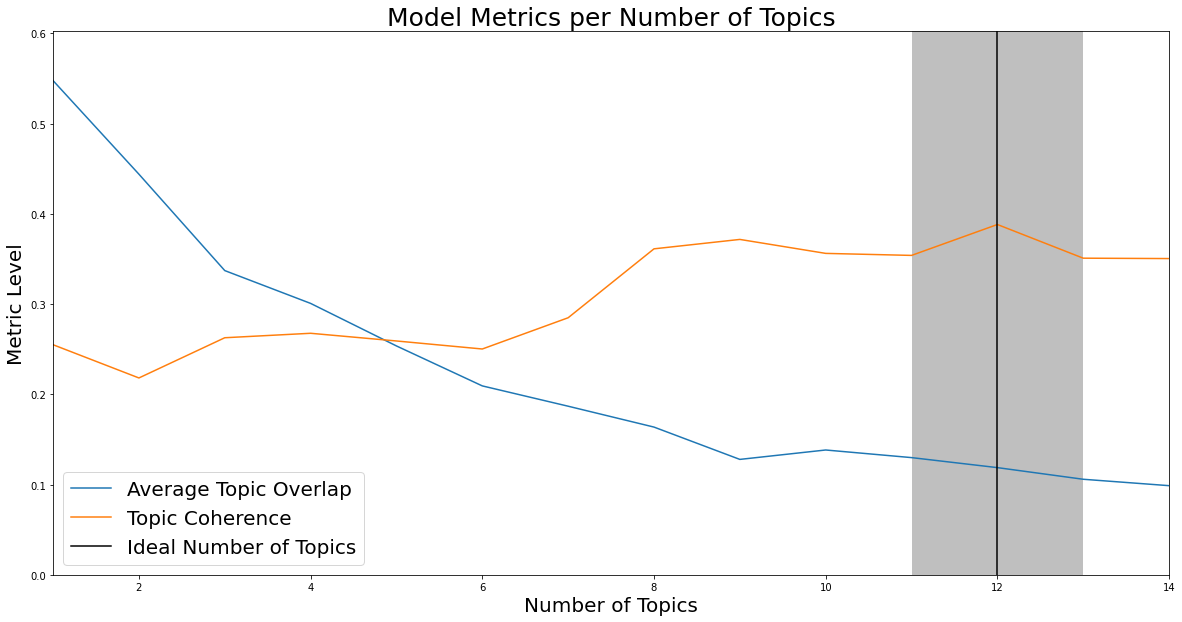

In [37]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  